## Exploration of land plots data

In [67]:
from collections import defaultdict
import math
from pprint import pprint
import re

import duckdb
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from shapely import wkb, wkt

Connecting to already built DB

In [2]:
con = duckdb.connect("plots_poland.duckdb")

In [3]:
con.execute("LOAD spatial")

Let's check what is inside

In [4]:
plots_df = con.execute(''' 
    SELECT * FROM plots
    LIMIT 5
''').df()

In [5]:
plots_df.T

,0,1,2,3,4
id_dzialki,142902_2.0002.52/2,142902_2.0002.51,142902_2.0002.45,142902_2.0002.54/1,142902_2.0002.329
numer_dzialki,52/2,51,45,54/1,329
nazwa_obrebu,BIELANY-WĄSY,BIELANY-WĄSY,BIELANY-WĄSY,BIELANY-WĄSY,BIELANY-WĄSY
numer_obrebu,0002,0002,0002,0002,0002
numer_jednostki,142902_2,142902_2,142902_2,142902_2,142902_2
nazwa_gminy,BIELANY,BIELANY,BIELANY,BIELANY,BIELANY
data,2026-01-31,2026-01-31,2026-01-31,2026-01-31,2026-01-31
pole_ewidencyjne,0.3915,0.717,0.1614,0.5,0.5299
klasouzytki_egib,"RIVb,RIVa","RIVb,Br/RIVb,Br/RIVa,Br/RV",Br/RIVb,"RVI,RV","RIVb,RIVa,Br/RV"
grupa_rejestrowa,1,7,7,7,7


Let's check if my two municipalities of interest can be found

In [6]:
municipalities = con.execute(''' 
    SELECT DISTINCT nazwa_gminy FROM plots
    WHERE LOWER(nazwa_gminy) LIKE '%konstancin%' OR LOWER(nazwa_gminy) LIKE '%wilanów%'
    ORDER BY nazwa_gminy
''').fetchall()

municipalities

[('Dzielnica Wilanów',), ('Konstancin-Jeziorna',)]

Some of the attributes might be empty. Let's see which and where

In [7]:
null_query = con.execute(''' 
SELECT 
    'SELECT ' || STRING_AGG('SUM(CASE WHEN ' || column_name || ' IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS ' || column_name || '_nulls', ', ') || ' FROM plots;' AS sql_command
FROM information_schema.columns
WHERE table_name = 'plots'
''').fetchone()[0]

In [8]:
null_query = null_query[:-1] + ''' WHERE LOWER(nazwa_gminy) LIKE '%konstancin%' OR LOWER(nazwa_gminy) LIKE '%wilanów%' '''

In [9]:
null_df = con.execute(null_query).df()
null_df.T

,0
id_dzialki_nulls,0.00000
numer_dzialki_nulls,0.00000
nazwa_obrebu_nulls,0.00000
numer_obrebu_nulls,0.00000
numer_jednostki_nulls,0.41189
nazwa_gminy_nulls,0.00000
data_nulls,0.00000
pole_ewidencyjne_nulls,0.41189
klasouzytki_egib_nulls,0.41189
grupa_rejestrowa_nulls,0.41189


In [10]:
plots_df = con.execute(''' 
    SELECT *, ST_AsText(geometry) as geom_wkt,
                       CASE
                           WHEN klasouzytki_egib IS NULL OR grupa_rejestrowa IS NULL THEN 1
                           ELSE 0
                       END AS are_atts_null
    FROM plots
    WHERE LOWER(nazwa_gminy) LIKE '%konstancin%' OR LOWER(nazwa_gminy) LIKE '%wilanów%'
''').df()

In [13]:
plots_df['geometry'] = plots_df['geom_wkt'].apply(wkt.loads)

In [14]:
plots_gdf = gpd.GeoDataFrame(plots_df, geometry='geometry', crs='EPSG:2180')

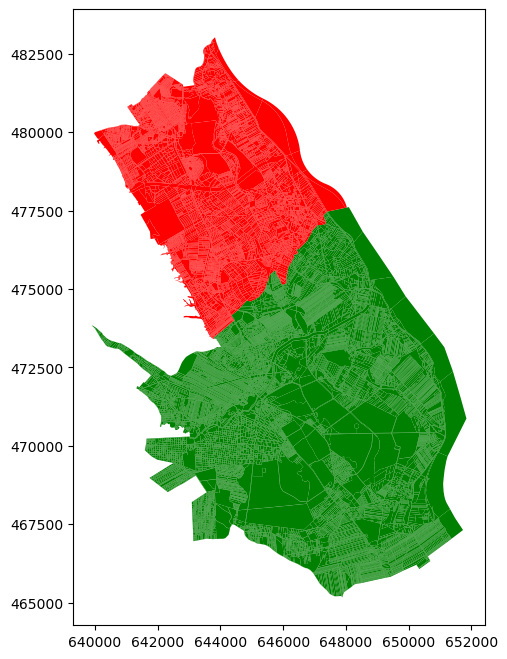

In [15]:
color_map = {0: "green", 1: "red"}

fig, ax = plt.subplots(figsize=(8, 8))

plots_gdf.plot(
    ax=ax,
    color=plots_gdf["are_atts_null"].map(color_map)
)

plt.show();

Wilanów does not have the key attributes, so I will focus my exploration on Konstancin

In [16]:
plots_gdf = plots_gdf.loc[plots_gdf['nazwa_gminy']=='Konstancin-Jeziorna']
plots_gdf.shape

(21883, 16)

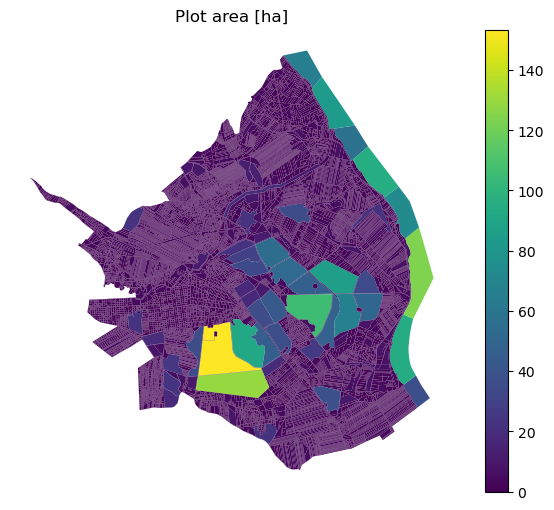

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plots_gdf.plot(
    column="pole_ewidencyjne",
    cmap="viridis",
    legend=True,
    ax=ax
)

ax.set_title("Plot area [ha]")
ax.set_axis_off()
plt.show();

In [18]:
plots_gdf['grupa_rejestrowa'].value_counts()

grupa_rejestrowa
7     16101
4      2156
16      795
15      652
13      605
1       576
2       361
11      297
5       133
8        68
10       52
9        47
6        31
3         8
14        1
Name: count, dtype: Int64

1. Na podstawie statusu podmiotów i przysługujących im wielkości udziałów, o których mowa w § 11 pkt 7, ustala się
następujące grupy rejestrowe:
1) grupa 1 – Skarb Państwa, jeżeli nie występuje w zbiegu z użytkownikami wieczystymi;
2) grupa 2 – Skarb Państwa, jeżeli występuje w zbiegu z użytkownikami wieczystymi;
3) grupa 3 – jednoosobowe spółki Skarbu Państwa, przedsiębiorstwa państwowe i inne państwowe osoby prawne;
4) grupa 4 – gminy, związki międzygminne lub metropolitalne, jeżeli nie występują w zbiegu z użytkownikami wieczystymi;
5) grupa 5 – gminy, związki międzygminne lub metropolitalne, jeżeli występują w zbiegu z użytkownikami wieczystymi;
6) grupa 6 – jednoosobowe spółki jednostek samorządu terytorialnego i inne osoby prawne, których organami założycielskimi
są organy samorządu terytorialnego;
7) grupa 7 – osoby fizyczne;
8) grupa 8 – spółdzielnie;
9) grupa 9 – kościoły i związki wyznaniowe;
10) grupa 10 – wspólnoty gruntowe;
11) grupa 11 – powiaty i związki powiatów, jeżeli nie występują w zbiegu z użytkownikami wieczystymi;
12) grupa 12 – powiaty i związki powiatów, jeżeli występują w zbiegu z użytkownikami wieczystymi;
13) grupa 13 – województwa, jeżeli nie występują w zbiegu z użytkownikami wieczystymi;
14) grupa 14 – województwa, jeżeli występują w zbiegu z użytkownikami wieczystymi;
15) grupa 15 – spółki prawa handlowego;
16) grupa 16 – inne podmioty ewidencyjne niewymienione w pkt 1–15. [źródło: https://arslege.pl/grupy-rejestrowe-dla-jednostek-rejestrowych/k1928/a133762/]

In [19]:
skarb_panstwa = [1, 2, 3]
gmina = [4, 5]
spolki_jst = [6]
osoby_fizyczne = [7]
spoldzielnie_wspolnoty = [8, 10]
kosciol = [9]
powiat = [11, 12]
wojewodztwo = [13, 14]
spolki_prywatne = [15]
inne = [16]

owner_type_map = {
    **{k: "Skarb Państwa" for k in skarb_panstwa},
    **{k: "Gmina" for k in gmina},
    **{k: "Społki JST" for k in spolki_jst},
    **{k: "Osoby fizyczne" for k in osoby_fizyczne},
    **{k: "Spółdzielnie wspólnoty" for k in spoldzielnie_wspolnoty},
    **{k: "Kościół" for k in kosciol},
    **{k: "Powiat" for k in powiat},
    **{k: "Województwo" for k in wojewodztwo},
    **{k: "Spółki prywatne" for k in spolki_prywatne},
    **{k: "Inny właściciel" for k in inne}
}

In [20]:
plots_gdf['owner_type'] = plots_gdf['grupa_rejestrowa'].map(owner_type_map)

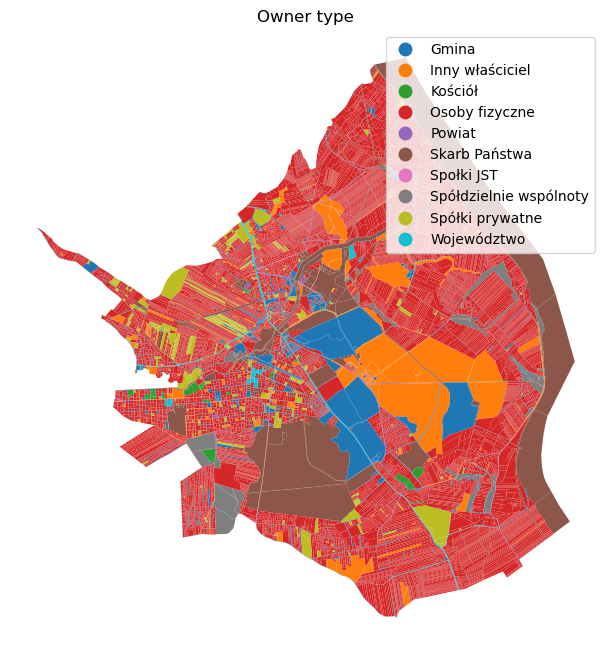

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

plots_gdf.plot(
    ax=ax,
    column='owner_type',
    categorical=True,
    legend=True
)

ax.set_title("Owner type")
ax.set_axis_off()
plt.show();

The "klasoużytki_egib" attribute shows land use types and soil quality. Let's parse this strings first

In [22]:
plots_gdf['klasouzytki_egib'].value_counts()

klasouzytki_egib
B                              5084
dr                             2633
Tp                              666
Bi                              502
RIVa                            437
                               ... 
PsV,SRIVb,dr,RIVb,B               1
Lz,RV,RIVa,RIVb,RIIIb             1
RIIIb,Lz,RIVb,RIVa,RV             1
RIVb,RIVa,RV,Lz                   1
PsIV,PsV,RIVa,Lz,RIIIb,RIVb       1
Name: count, Length: 3213, dtype: int64

In [23]:
roman_map = {
    "I": 1,
    "II": 2,
    "III": 3,
    "IV": 4,
    "V": 5,
    "VI": 6
}

pattern = re.compile(r"^([A-Za-z]+?)(I{1,3}|IV|V|VI)?([ab])?$")

In [24]:
def parse_classified_land_use_type(s):
    result = defaultdict(list)
    
    for part in s.split(","):
        match = pattern.match(part)
        if not match:
            continue
        key, roman, suffix = match.groups()

        if roman is None:
            value = 0
        else:
            value = roman_map[roman]
            if suffix == "b":
                value += 0.5
        
        result[key].append(value)
    
    return dict(result)

In [25]:
plots_gdf['klasouzytki_egib_parsed'] = plots_gdf['klasouzytki_egib'].apply(parse_classified_land_use_type)

In [26]:
plots_gdf.head().T

,90,92,93,115,120
id_dzialki,141802_5.0012.19/3,141802_5.0012.19/2,141802_5.0012.12,141802_5.0012.4/2,141802_5.0012.40
numer_dzialki,19/3,19/2,12,4/2,40
nazwa_obrebu,KĘPA OKRZEWSKA,KĘPA OKRZEWSKA,KĘPA OKRZEWSKA,KĘPA OKRZEWSKA,KĘPA OKRZEWSKA
numer_obrebu,0012,0012,0012,0012,0012
numer_jednostki,141802_5,141802_5,141802_5,141802_5,141802_5
nazwa_gminy,Konstancin-Jeziorna,Konstancin-Jeziorna,Konstancin-Jeziorna,Konstancin-Jeziorna,Konstancin-Jeziorna
data,2026-01-31,2026-01-31,2026-01-31,2026-01-31,2026-01-31
pole_ewidencyjne,0.46,0.1,0.99,0.0782,0.16
klasouzytki_egib,"RII,RIIIb,RIIIa,BrRIIIb","B,RIIIa","RIIIb,RIVb,RIVa,PsIV,PsIII",dr,RIIIa
grupa_rejestrowa,7,7,7,1,7


In [29]:
all_parsed = plots_gdf['klasouzytki_egib_parsed'].to_list()
all_parsed[:3]

[{'R': [2, 3.5, 3], 'BrR': [3.5]},
 {'B': [0], 'R': [3]},
 {'R': [3.5, 4.5, 4], 'Ps': [4, 3]}]

In [39]:
distincts_types = sorted(list(set([k for dct in all_parsed for k in dct.keys()])))
pprint(distincts_types, width=200)

['B', 'BLs', 'BR', 'Bi', 'Bp', 'BrPs', 'BrR', 'Bz', 'Ls', 'Lz', 'LzrPs', 'LzrR', 'N', 'Ps', 'R', 'SPs', 'SR', 'Tk', 'Tp', 'Tr', 'W', 'WLs', 'WLz', 'WPs', 'WR', 'Wp', 'Ws', 'WsrPs', 'WsrR', 'dr']


In [43]:
for land_type in distincts_types:
    plots_gdf[land_type + '_is_present'] = plots_gdf['klasouzytki_egib_parsed'].apply(lambda x: True if land_type in x.keys() else False)

In [48]:
plots_gdf.iloc[[0]]

,id_dzialki,numer_dzialki,nazwa_obrebu,numer_obrebu,numer_jednostki,nazwa_gminy,data,pole_ewidencyjne,klasouzytki_egib,grupa_rejestrowa,...,W_is_present,WLs_is_present,WLz_is_present,WPs_is_present,WR_is_present,Wp_is_present,Ws_is_present,WsrPs_is_present,WsrR_is_present,dr_is_present
90,141802_5.0012.19/3,19/3,KĘPA OKRZEWSKA,0012,141802_5,Konstancin-Jeziorna,2026-01-31,0.46,"RII,RIIIb,RIIIa,BrRIIIb",7,...,False,False,False,False,False,False,False,False,False,False


In [53]:
egib_colors = {
    'B': '#e41a1c',
    'BLs': '#fb8072',
    'BR': '#f781bf',
    'Bi': '#ef3b2c',
    'Bp': '#fc9272',
    'BrPs': '#fdb462',
    'BrR': '#fd8d3c',
    'Bz': '#ff9896',

    'Ls': '#006400',
    'Lz': '#228B22',
    'LzrPs': '#66a61e',
    'LzrR': '#4daf4a',

    'R': '#ffd92f',
    'SR': '#e6ab02',
    'Ps': '#a6d854',
    'SPs': '#b3de69',

    'W': '#1f78b4',
    'WLs': '#3182bd',
    'WLz': '#6baed6',
    'WPs': '#9ecae1',
    'WR': '#08519c',
    'Wp': '#4ea3d8',
    'Ws': '#2171b5',
    'WsrPs': '#74c476',
    'WsrR': '#41ab5d',

    'Tk': '#969696',
    'Tp': '#bdbdbd',
    'Tr': '#737373',
    'dr': '#525252',

    'N': '#252525'
}

In [59]:
cols = 6
rows = math.ceil(len(distincts_types) / cols)
cols, rows

(6, 5)

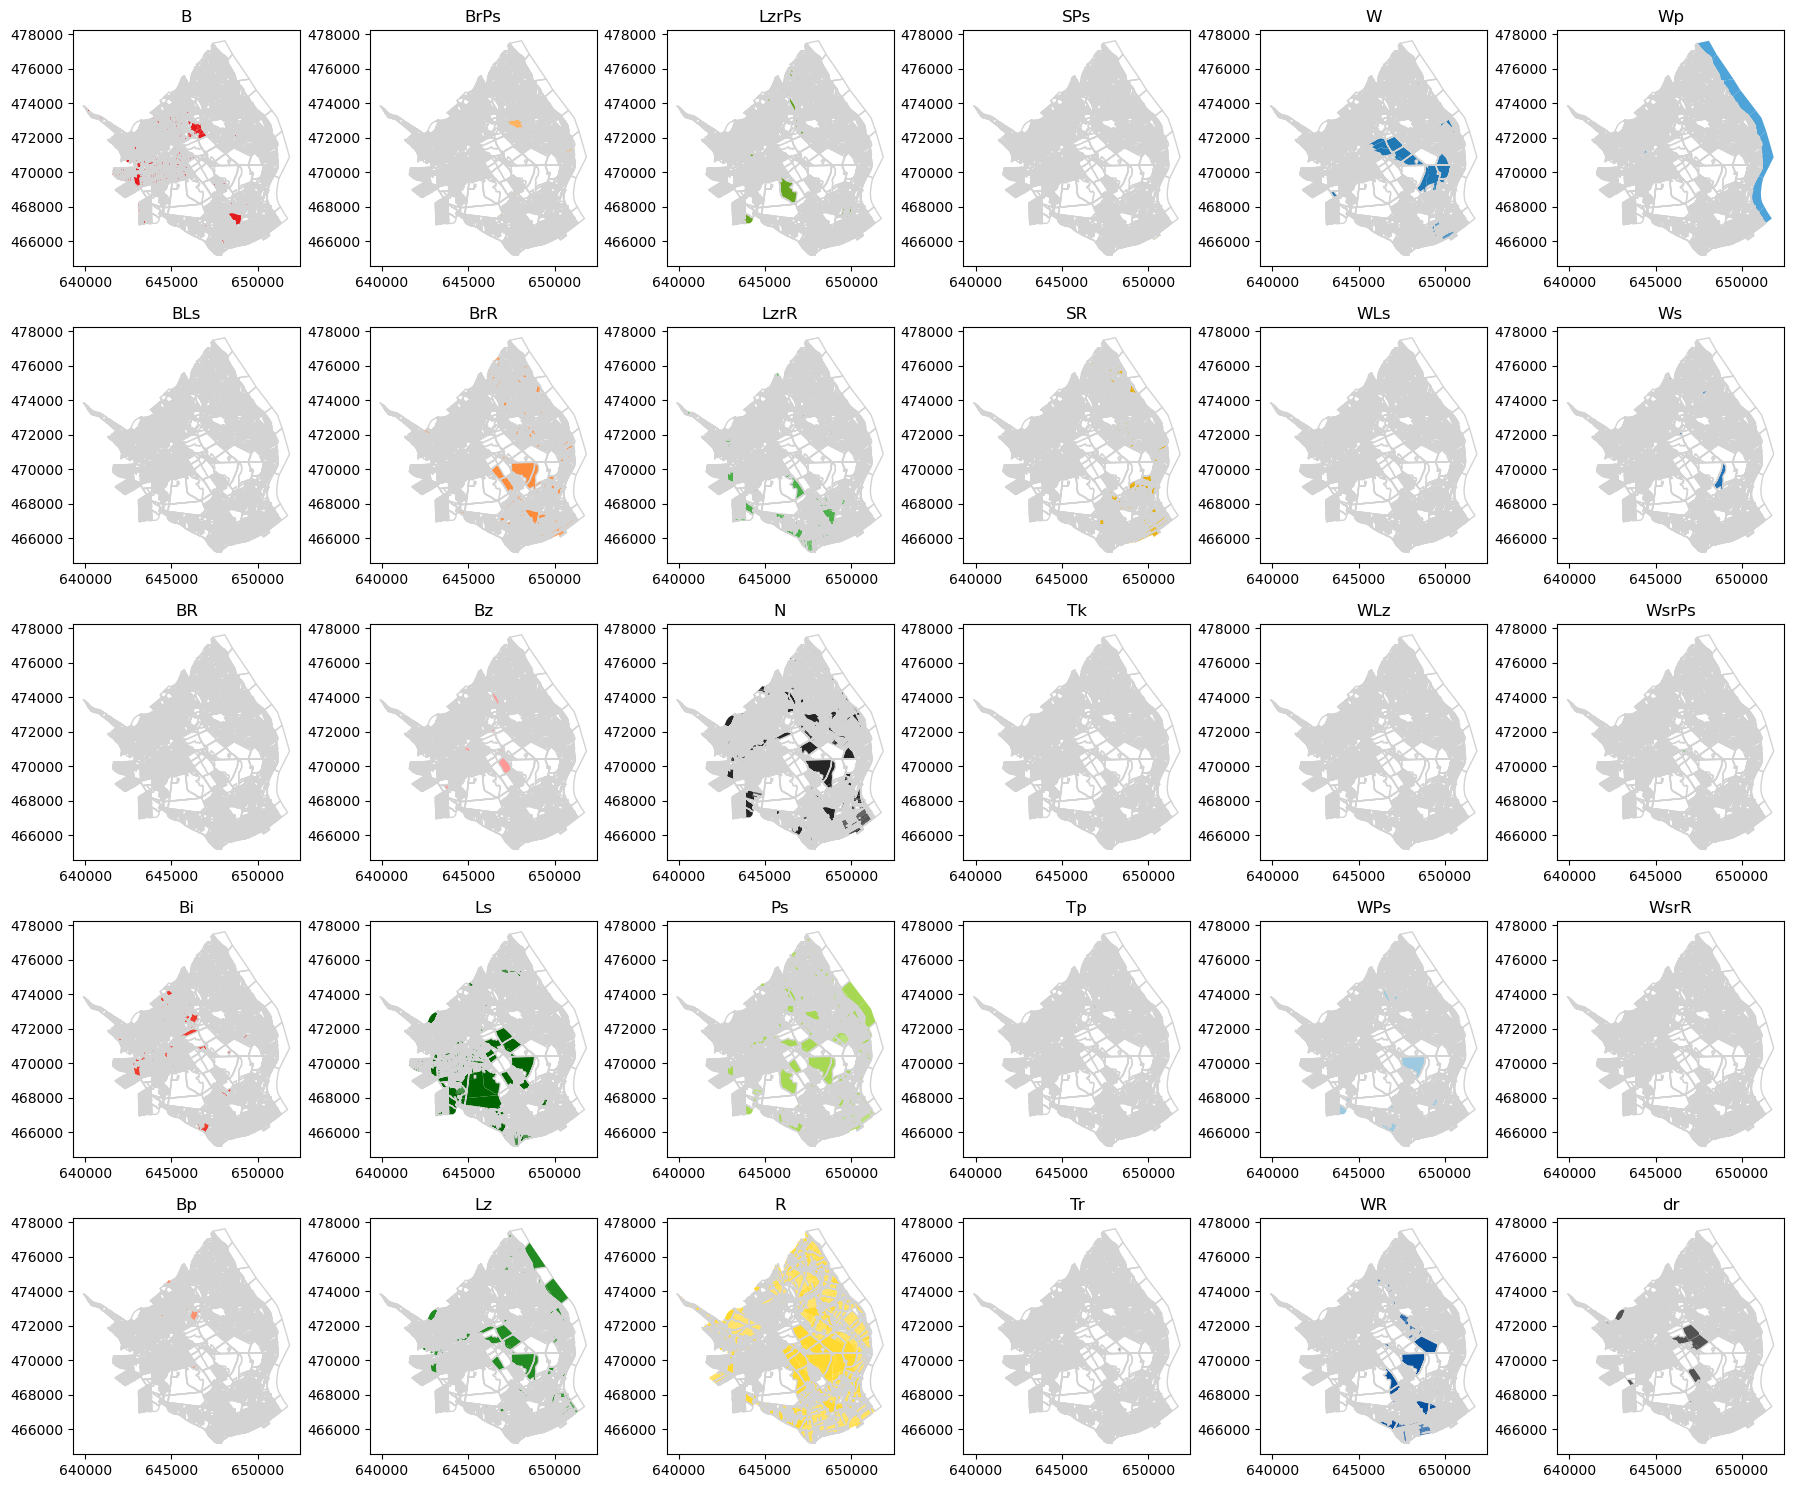

In [63]:
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

i, j = 0, 0

for land_type in distincts_types:
    col_name = land_type + '_is_present'
    plots_gdf[plots_gdf[col_name]].plot(
        ax=axes[i,j],
        color=egib_colors[land_type]
    )
    plots_gdf[~plots_gdf[col_name]].plot(
        ax=axes[i,j],
        color='none',
        edgecolor='lightgrey'
    )
    axes[i,j].set_title(land_type)

    if i < rows - 1:
        i += 1
    else:
        i = 0
        j += 1 

plt.tight_layout()
plt.show();

In [65]:
plots_gdf['min_soil_class'] = plots_gdf['klasouzytki_egib_parsed'].apply(lambda x: min(x['R']) if 'R' in x.keys() else None)
plots_gdf['max_soil_class'] = plots_gdf['klasouzytki_egib_parsed'].apply(lambda x: max(x['R']) if 'R' in x.keys() else None)

In [68]:
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

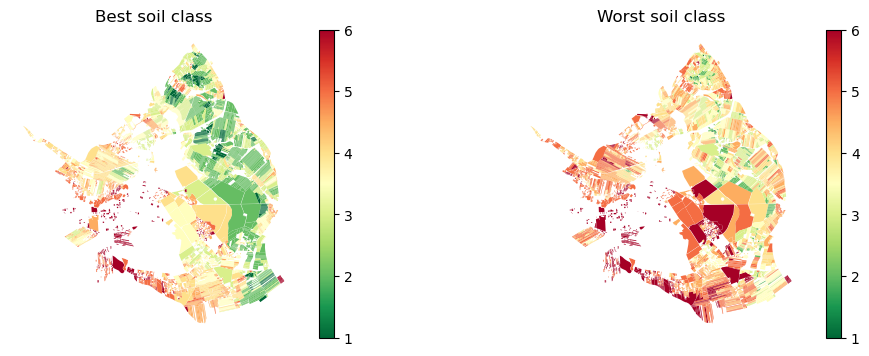

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plots_gdf.plot(
    column="min_soil_class",
    cmap='RdYlGn_r',
    legend=True,
    ax=ax[0]
)
ax[0].set_title("Best soil class")
ax[0].set_axis_off()

plots_gdf.plot(
    column="max_soil_class",
    cmap='RdYlGn_r',
    legend=True,
    ax=ax[1]
)
ax[1].set_title("Worst soil class")
ax[1].set_axis_off()
plt.show();